In [ ]:
Полина Чижик, лабораторная 7

ResNet'ы – это мощные глубокие нейронные сети, появившиеся на основании работ Кайминга Хе и пр. в 2015 и 2016, чьи прорывы позволили обучать сотни или даже тысячи слоев с хорошей производительностью. 
Архитектура ResNet: ResNet обычно оперирует блоками относительно небольшой глубины, работающих параллельно, а не прогоняя последовательно по всей длине сети

In [1]:
import torch
import random
import numpy as np
import time
from torchvision.models import resnet18

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torchvision.datasets

random.seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [3]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

In [5]:
len(y_train), len(y_test)

(50000, 10000)

In [6]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [7]:
X_train /= 255.
X_test /= 255.

In [8]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

tensor(3)  tensor(8)  tensor(8)  tensor(0)  tensor(6)  tensor(6)  tensor(1)  tensor(6)  tensor(3)  tensor(1)  

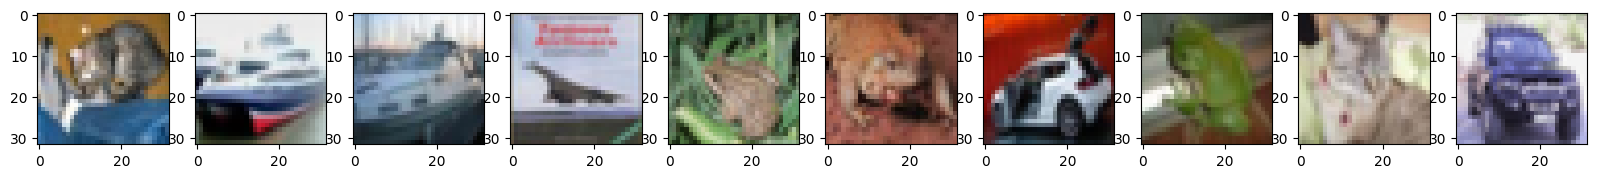

In [9]:
plt.figure(figsize=(20,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_test[i])
    print(y_test[i], end='  ')

In [10]:
X_train.shape, y_train.shape

(torch.Size([50000, 32, 32, 3]), torch.Size([50000]))

In [11]:
X_test = X_test.permute(0, 3, 1, 2)

In [12]:
X_train = X_train.permute(0, 3, 1, 2)
X_train.shape

torch.Size([50000, 3, 32, 32])

In [17]:
def train(
    net, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    batch_size=256, 
    steps=50, 
    info_show=10,
    weight_decay=0, 
    save_net_state=False, 
    verbose=True
):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net=net.to(device)
    loss = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3, weight_decay=weight_decay)
    cash, history = [],  []
    t = time.time()
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for step in range(1, steps+1):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()
            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
            preds = net.forward(X_batch)
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()
        net.eval()
        with torch.no_grad():
             test_preds = net.forward(X_test)
        loss_value = loss(test_preds, y_test).item()
        history.append(loss_value)
        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().item()
        cash.append(accuracy)
        if verbose:
            if step % info_show == 0:
                print('Train Epoch: {} Time: {} Accuracy: {}, GPU_Mem_alloc: {} GPU_Mem_cashed: {}'\
                  .format(step, time.strftime("%H:%M:%S", time.gmtime(time.time() - t)), accuracy, \
                            torch.cuda.memory_allocated(), torch.cuda.memory_cached()))
              
    net_state = net.state_dict()
    del net
    if save_net_state:
        return cash, history, net_state
    else:
        return cash, history

accuracies = {}
losses = {}  
        

In [18]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(15, 6)})

def acc_loss_graph(accuracies, losses, net_list, save_file_name='plot.png', download=False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for experiment_id in net_list:
        ax1.plot(accuracies[experiment_id], label=experiment_id)
    ax1.legend()
    ax1.set_title('Validation Accuracy')
    fig.tight_layout()
    for experiment_id in net_list:
        ax2.plot(losses[experiment_id], label=experiment_id)
    ax2.legend()
    ax2.set_title('Validation Loss');
    fig.tight_layout()

In [19]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)
        self.batch_drop2 = torch.nn.Dropout2d(p=0.15, inplace=False)
        self.batch_drop1 = torch.nn.Dropout(p=0.15, inplace=False)
        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)
        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)
        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)
        self.fc3   = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.batch_drop2(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.batch_drop2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)
        x = self.batch_drop2(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.batch_drop1(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.batch_drop1(x)
        x = self.fc3(x)
        return x
 

In [20]:
accuracies['cifar_net'], losses['cifar_net'] = train(CIFARNet(), X_train, y_train, X_test, y_test)

d:\python\projects_384\po\venv\lib\site-packages\torch\cuda\memory.py:391: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


Train Epoch: 10 Time: 00:00:32 Accuracy: 0.7292999625205994, GPU_Mem_alloc: 285360128 GPU_Mem_cashed: 2338324480
Train Epoch: 20 Time: 00:01:03 Accuracy: 0.7342000007629395, GPU_Mem_alloc: 285360128 GPU_Mem_cashed: 2338324480
Train Epoch: 30 Time: 00:01:36 Accuracy: 0.739799976348877, GPU_Mem_alloc: 285360128 GPU_Mem_cashed: 2338324480
Train Epoch: 40 Time: 00:02:08 Accuracy: 0.7360000014305115, GPU_Mem_alloc: 285360128 GPU_Mem_cashed: 2338324480
Train Epoch: 50 Time: 00:02:41 Accuracy: 0.7372999787330627, GPU_Mem_alloc: 285360128 GPU_Mem_cashed: 2338324480


Задание 3

In [21]:
accuracies['resnet18'], losses['resnet18'] = train(resnet18(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:03:15 Accuracy: 0.7188000082969666, GPU_Mem_alloc: 498315776 GPU_Mem_cashed: 3024093184
Train Epoch: 20 Time: 00:06:34 Accuracy: 0.7172999978065491, GPU_Mem_alloc: 498315776 GPU_Mem_cashed: 3024093184
Train Epoch: 30 Time: 00:10:00 Accuracy: 0.7272999882698059, GPU_Mem_alloc: 498315776 GPU_Mem_cashed: 3024093184
Train Epoch: 40 Time: 00:13:18 Accuracy: 0.72079998254776, GPU_Mem_alloc: 498315776 GPU_Mem_cashed: 3024093184
Train Epoch: 50 Time: 00:16:40 Accuracy: 0.7179999947547913, GPU_Mem_alloc: 498315776 GPU_Mem_cashed: 3024093184


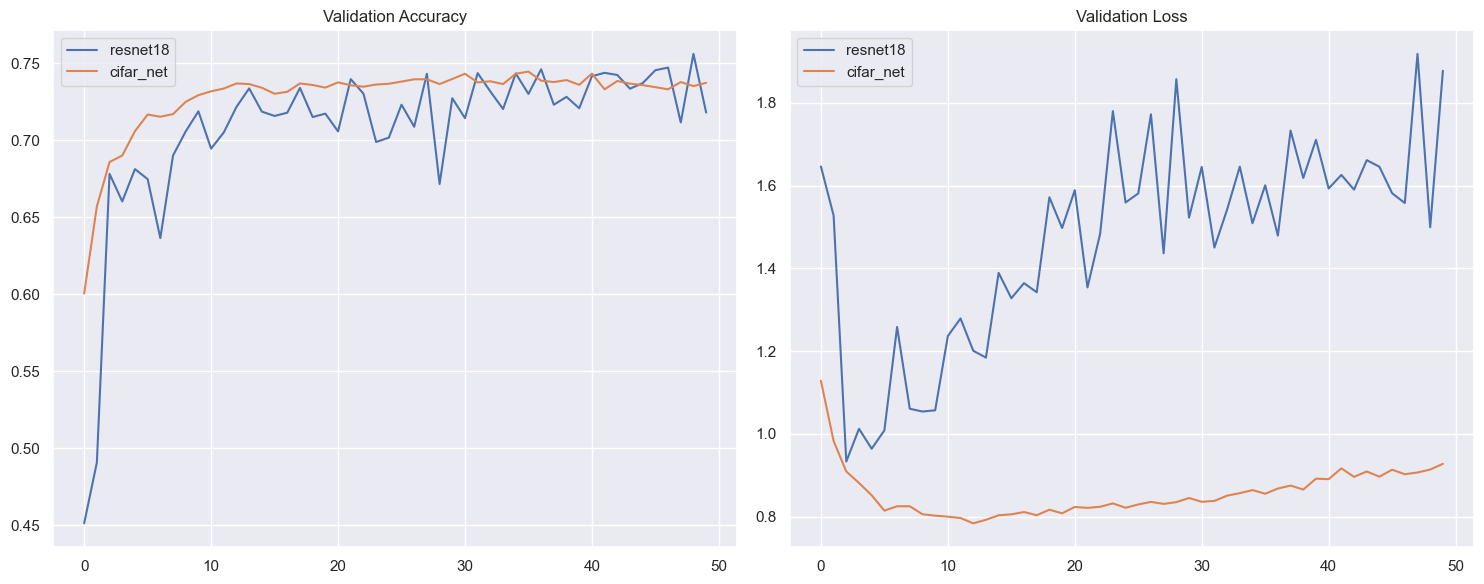

In [22]:
acc_loss_graph(accuracies, losses, ['resnet18', 'cifar_net'])

In [23]:
class LambdaLayer(torch.nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(torch.nn.Module):
    expansion = 1

    def __init__(
        self, 
        in_planes, 
        planes, 
        stride=1, 
        option='A', 
        use_batch_norm=True, 
        use_drop_out=False,
        d_out_p=0.5
    ):
        super(BasicBlock, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.act  = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.d_out2 = torch.nn.Dropout2d(d_out_p)
        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                self.shortcut = LambdaLayer(
                    lambda x: torch.nn.functional.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     torch.nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     torch.nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
            out = self.bn1(out)
        if self.use_drop_out:
            out = self.d_out1(out) 
        out = self.act(out)
        out = self.conv2(out) 
        if self.use_batch_norm:
            out = self.bn2(out)
        if self.use_drop_out:
            out = self.d_out2(out)
        out += self.shortcut(x)
        out = self.act(out)
        return out


class ResNet(torch.nn.Module):
    def __init__(self, block, num_blocks, num_classes=10,
                 use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
        super(ResNet, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_drop_out = use_drop_out
        self.d_out_p = d_out_p
        self.in_planes = 16
        self.act  = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.d_out1 = torch.nn.Dropout2d(d_out_p)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = torch.nn.Linear(64, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(
                self.in_planes, planes, stride,
                use_batch_norm=self.use_batch_norm,
                use_drop_out=self.use_drop_out, 
                d_out_p=self.d_out_p))
            self.in_planes = planes * block.expansion

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        if self.use_batch_norm:
            out = self.bn1(out)
        if self.use_drop_out:
            out = self.d_out1(out)
          
        out = self.act(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = torch.nn.functional.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
        

In [24]:
def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])

def resnet110_d_out15():
    return ResNet(BasicBlock, [18, 18, 18], use_drop_out=True, d_out_p=0.15)

def resnet110_no_bn():
    return ResNet(BasicBlock, [18, 18, 18], use_batch_norm=False, use_drop_out=True, d_out_p=0.15) 
  
def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])  
  
def resnet20_d_out5():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True)
  
def resnet20_d_out3(**kwargs):
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.3)
  
def resnet20_d_out8():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.8)
  
def resnet20_d_out15():
    return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=0.15)

In [25]:
torch.cuda.is_available()

True

Задание 4, 5

In [26]:
accuracies['resnet110_d_out15'], losses['resnet110_d_out15'] = \
    train(resnet110_d_out15(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:17:34 Accuracy: 0.7993999719619751, GPU_Mem_alloc: 296015360 GPU_Mem_cashed: 3024093184
Train Epoch: 20 Time: 00:35:16 Accuracy: 0.8233999609947205, GPU_Mem_alloc: 296015360 GPU_Mem_cashed: 3024093184
Train Epoch: 30 Time: 00:52:49 Accuracy: 0.8438000082969666, GPU_Mem_alloc: 296015360 GPU_Mem_cashed: 3024093184
Train Epoch: 40 Time: 01:09:58 Accuracy: 0.8468999862670898, GPU_Mem_alloc: 296015360 GPU_Mem_cashed: 3024093184
Train Epoch: 50 Time: 01:35:49 Accuracy: 0.8454999923706055, GPU_Mem_alloc: 296015360 GPU_Mem_cashed: 3024093184


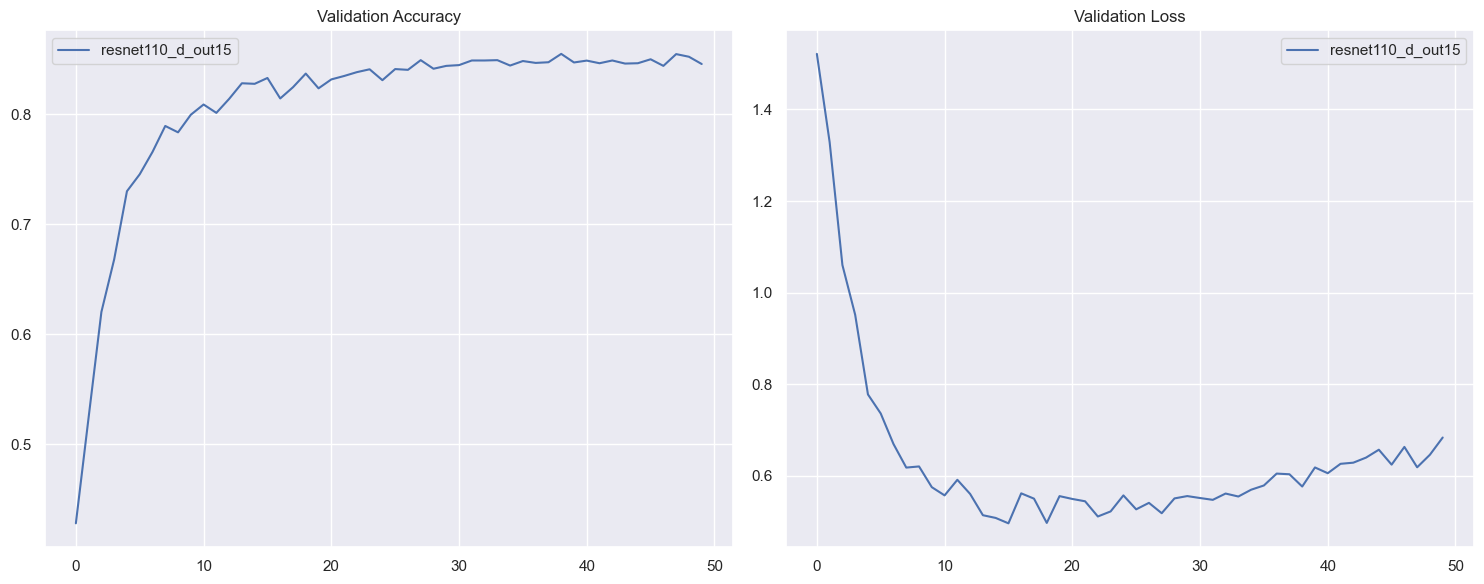

In [27]:
acc_loss_graph(accuracies, losses, ['resnet110_d_out15'])

In [28]:
accuracies['resnet110_no_bn'], losses['resnet110_no_bn'] = train(resnet110_no_bn(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:27:04 Accuracy: 0.6101999878883362, GPU_Mem_alloc: 295680512 GPU_Mem_cashed: 3024093184
Train Epoch: 20 Time: 00:54:06 Accuracy: 0.6894999742507935, GPU_Mem_alloc: 295680512 GPU_Mem_cashed: 3024093184
Train Epoch: 30 Time: 01:21:13 Accuracy: 0.7145999670028687, GPU_Mem_alloc: 295680512 GPU_Mem_cashed: 3024093184
Train Epoch: 40 Time: 01:47:24 Accuracy: 0.7310000061988831, GPU_Mem_alloc: 295680512 GPU_Mem_cashed: 3024093184
Train Epoch: 50 Time: 02:14:33 Accuracy: 0.7156999707221985, GPU_Mem_alloc: 295680512 GPU_Mem_cashed: 3024093184


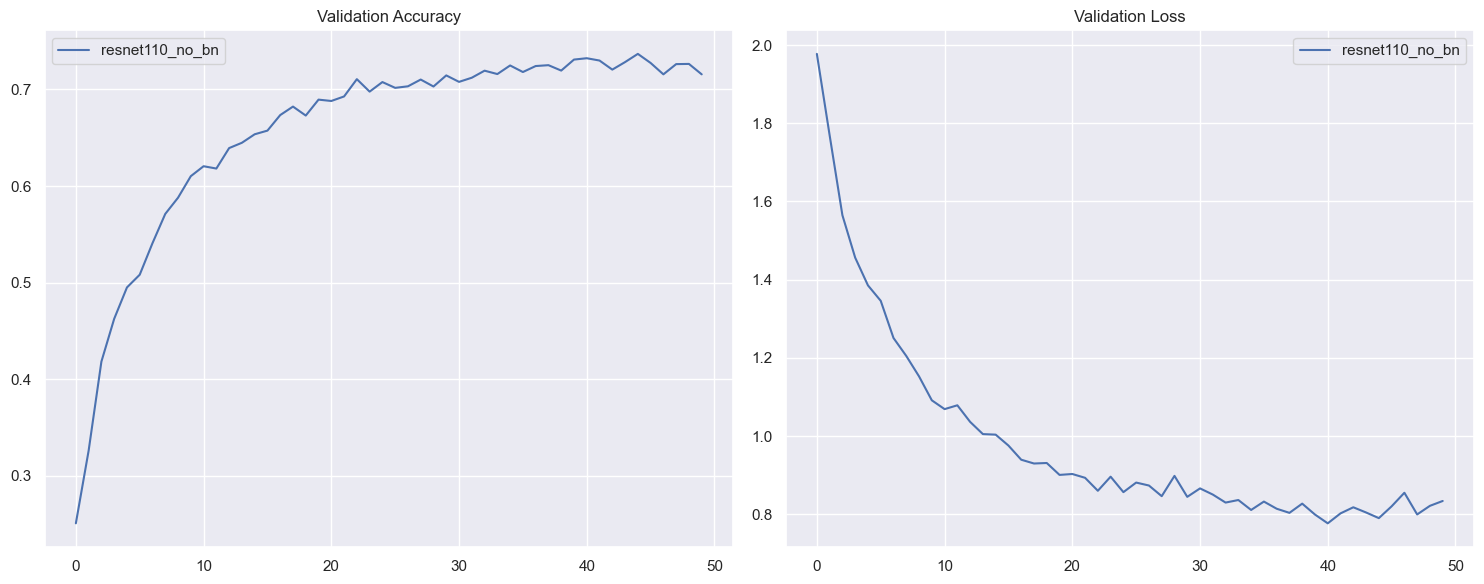

In [29]:
acc_loss_graph(accuracies, losses, ['resnet110_no_bn'])

Итог реализации ResNet без BatchNorm: нейросеть не смогла продвинуться в точности предсказаний за 50 эпох

In [30]:
accuracies['resnet20_d15'], losses['resnet20_d15'] = train(resnet20_d_out15(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:05:15 Accuracy: 0.7569999694824219, GPU_Mem_alloc: 272284160 GPU_Mem_cashed: 3024093184
Train Epoch: 20 Time: 00:10:40 Accuracy: 0.8129000067710876, GPU_Mem_alloc: 272284160 GPU_Mem_cashed: 3024093184
Train Epoch: 30 Time: 00:16:22 Accuracy: 0.8348000049591064, GPU_Mem_alloc: 272284160 GPU_Mem_cashed: 3024093184
Train Epoch: 40 Time: 00:22:13 Accuracy: 0.8431999683380127, GPU_Mem_alloc: 272284160 GPU_Mem_cashed: 3024093184
Train Epoch: 50 Time: 00:28:03 Accuracy: 0.8432999849319458, GPU_Mem_alloc: 272284160 GPU_Mem_cashed: 3024093184


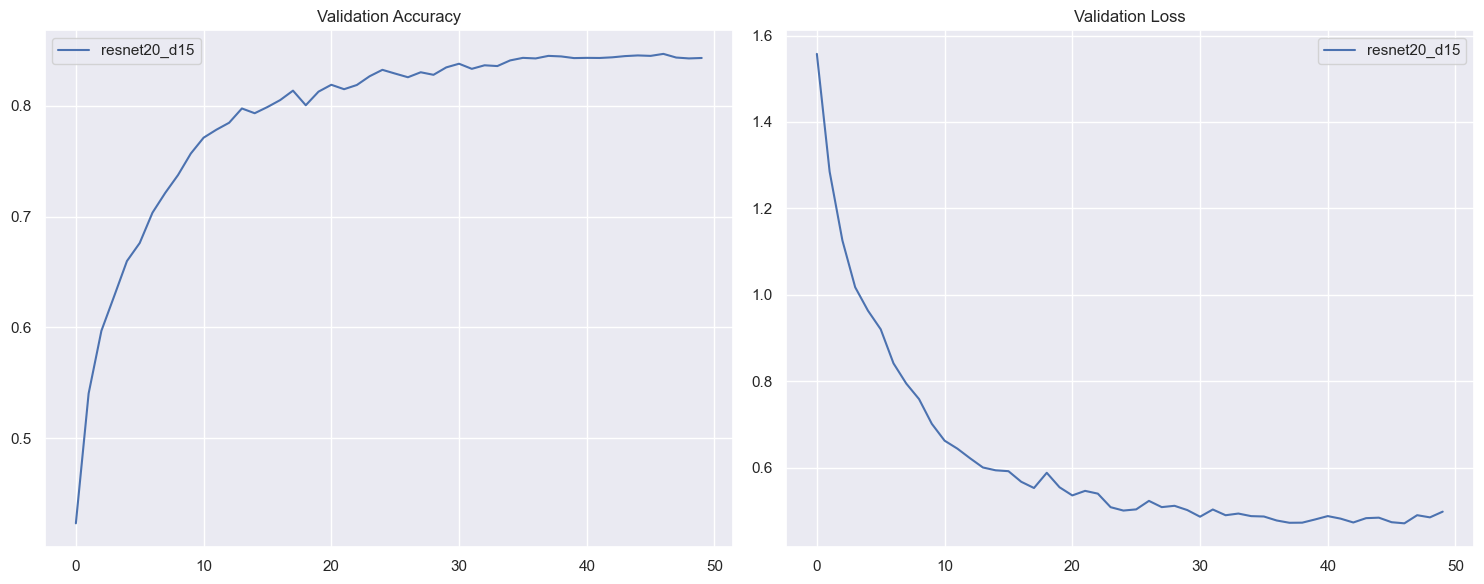

In [31]:
acc_loss_graph(accuracies, losses, ['resnet20_d15'])

In [32]:
accuracies['resnet20_d5'], losses['resnet20_d5'] =  train(resnet20_d_out5(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:05:30 Accuracy: 0.40209999680519104, GPU_Mem_alloc: 272284160 GPU_Mem_cashed: 3024093184
Train Epoch: 20 Time: 00:10:45 Accuracy: 0.47279998660087585, GPU_Mem_alloc: 272284160 GPU_Mem_cashed: 3024093184
Train Epoch: 30 Time: 00:16:09 Accuracy: 0.5292999744415283, GPU_Mem_alloc: 272284160 GPU_Mem_cashed: 3024093184
Train Epoch: 40 Time: 00:19:41 Accuracy: 0.5845000147819519, GPU_Mem_alloc: 272284160 GPU_Mem_cashed: 3024093184
Train Epoch: 50 Time: 00:24:51 Accuracy: 0.6087999939918518, GPU_Mem_alloc: 272284160 GPU_Mem_cashed: 3024093184


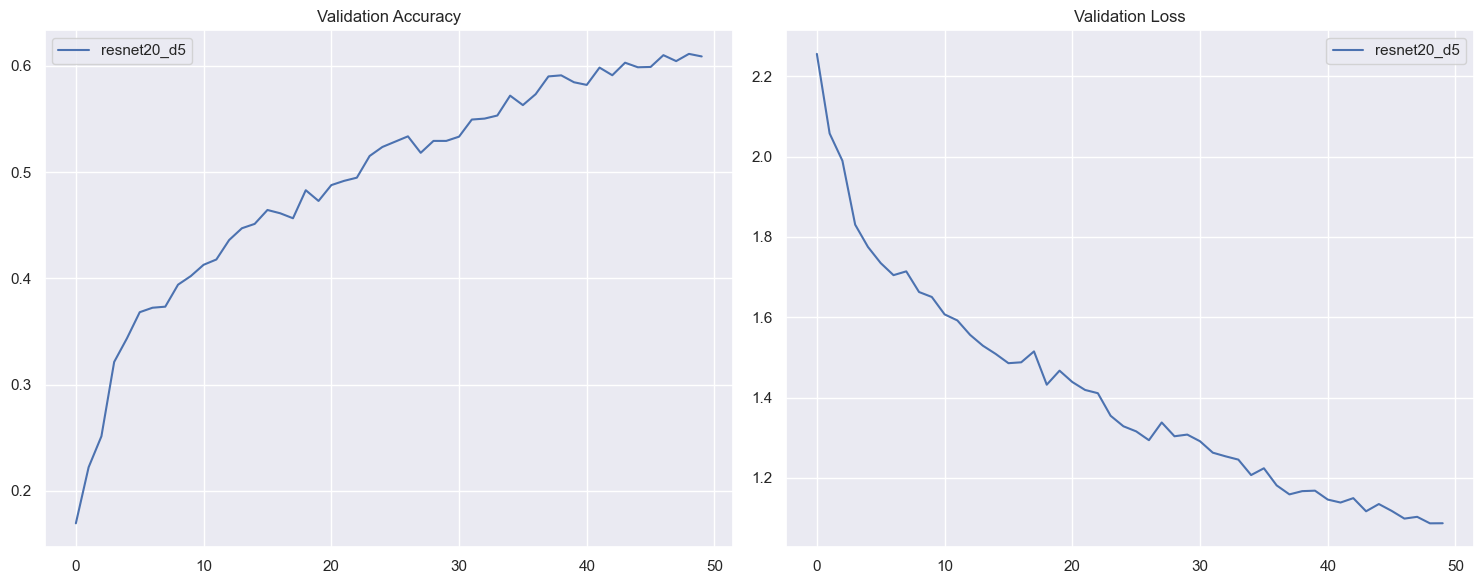

In [33]:
acc_loss_graph(accuracies, losses, ['resnet20_d5'])

In [35]:
accuracies['resnet20_d5_wd5'], losses['resnet20_d5_wd3'] = train(resnet20_d_out5(), X_train, y_train, X_test, y_test, batch_size=256, steps=50, info_show=10, weight_decay=1e-3)

Train Epoch: 10 Time: 00:12:25 Accuracy: 0.4318999946117401, GPU_Mem_alloc: 272284160 GPU_Mem_cashed: 3024093184
Train Epoch: 20 Time: 00:25:23 Accuracy: 0.5054999589920044, GPU_Mem_alloc: 272284160 GPU_Mem_cashed: 3024093184
Train Epoch: 30 Time: 00:35:37 Accuracy: 0.5819000005722046, GPU_Mem_alloc: 272284160 GPU_Mem_cashed: 3024093184
Train Epoch: 40 Time: 00:39:12 Accuracy: 0.6208999752998352, GPU_Mem_alloc: 272284160 GPU_Mem_cashed: 3024093184
Train Epoch: 50 Time: 00:42:18 Accuracy: 0.6477999687194824, GPU_Mem_alloc: 272284160 GPU_Mem_cashed: 3024093184


KeyError: 'resnet20_d5_wd3'

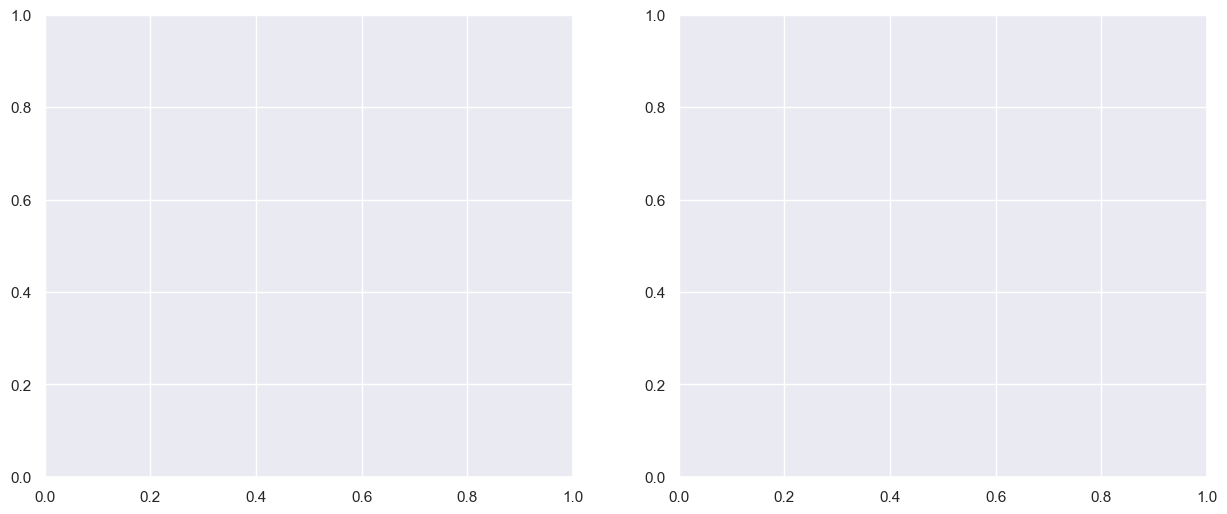

In [37]:
acc_loss_graph(accuracies, losses, ['resnet20_d5_wd3'])

Наилучший результат показала ResNet20 с дропаутом = 0.15